<a href="https://colab.research.google.com/github/12dylan3/LSTockMarket-Predictions/blob/main/OriginalPaperModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from functools import reduce
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Preprocess

In [ ]:
def get_data(url):
    """
    read the stock data and split into train and test
    :param url: url to raw csv from github.
    :return: Tuple of train and test opening prices
    """

    sequence_len = 50

    # Done TODO: load training data from training file.
    test_ratio = 0.2
    
    data = pd.read_csv(url)
    data = data.drop(['Date', 'High', 'Low', 'Close','Adj Close', 'Volume'], axis=1)

    num_data_points = data.shape[0]
    split_index = math.floor(num_data_points*(1-test_ratio))

    train_data = data[:split_index]
    test_data = data[split_index:]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    train_sequences = []
    train_labels = []
    for i in range(sequence_len, train_data.shape[0]):
      train_sequences.append(train_data[i-sequence_len:i])
      train_labels.append(train_data[i, 0])
    
    test_sequences = []
    test_labels = []
    for i in range(sequence_len, test_data.shape[0]):
      test_sequences.append(test_data[i-sequence_len:i])
      test_labels.append(test_data[i, 0])

    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    return (train_sequences, train_labels, test_sequences, test_labels, scaler)

Model Class

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        """
        The Model class predicts the next opening price for a stock.
        MODEL BASED ON WORK BY Adil Moghara and Mhamed Hamicheb
        https://www.sciencedirect.com/science/article/pii/S1877050920304865

        """

        super(Model, self).__init__()

        self.initial_state = None

        self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

        self.batch_size = 50

        self.num_feats = 1


        self.lstm1 = tf.keras.layers.LSTM(96, activation='relu', return_sequences = True, input_shape = (50,self.num_feats))
        self.lstm2 = tf.keras.layers.LSTM(96, activation='relu', return_sequences = True)
        self.lstm3 = tf.keras.layers.LSTM(96, activation='relu', return_sequences = True)
        self.lstm4 = tf.keras.layers.LSTM(96, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(.10)
        self.dropout2 = tf.keras.layers.Dropout(.10)
        self.dropout3 = tf.keras.layers.Dropout(.10)
        self.dropout4 = tf.keras.layers.Dropout(.10)
        self.final_dense = tf.keras.layers.Dense(1)


    def call(self, inputs):
        """
        :param train_sequences: stock data for 50 day period of shape (batch_size, 50, 1)
        :return: the scaled predicted opening price for the next (51st) day  
        """


        lstm1_out = self.lstm1(inputs)
        lstm1_out = self.dropout1(lstm1_out)

        lstm2_out = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)

        lstm3_out = self.lstm3(lstm2_out)
        lstm3_out = self.dropout3(lstm3_out)

        lstm4_out = self.lstm4(lstm3_out)
        lstm4_out = self.dropout4(lstm4_out)

        final_out = self.final_dense(lstm4_out)

        final_out = tf.convert_to_tensor(final_out)

        return final_out

    def loss(self, predictions, labels):
        """
        Calculates MSE loss of the prediction
        
        :param predictions: a matrix of shape (batch_size, 1) as a tensor
        :param labels: matrix of shape (batch_size, 1) containing the labels
        :return: the loss of the model as a tensor of size 1
        """

        loss = tf.keras.losses.mean_squared_error(labels, predictions)
        print("L: ", loss)
        loss = tf.reduce_mean(loss)

        return loss

Train and Results

In [ ]:
def train(model, train_sequences, train_labels):
    """
    Runs through one epoch - all training examples.

    :param model: the initilized model to use for forward and backward pass
    :param train_sequences: train inputs (all inputs for training) of shape (num_inputs,)
    :param train_labels: train labels (all labels for training) of shape (num_labels,)
    :return: None
    """
    #TODO: Fill in
    print("In Train")

    i = 0
    while i < len(train_sequences)-model.batch_size:
        batch_inputs = train_sequences[i:i+model.batch_size]
        batch_labels = train_labels[i:i+model.batch_size]


        with tf.GradientTape() as tape:
            call_return = model.call(batch_inputs)
            loss = model.loss(call_return, batch_labels)

        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        i += model.batch_size

    pass


def test(model, test_sequences, test_labels):
    """
    Runs through one epoch - all training examples.

    :param model: the initilized model to use for forward and backward pass
    :param train_sequences: train inputs (all inputs for training) of shape (num_inputs,)
    :param train_labels: train labels (all labels for training) of shape (num_labels,)
    :return: None
    """
    #TODO: Fill in
    print("In Test")

    loss_list = []
    predictions_list = []

    i = 0
    count = 0
    while i < len(test_sequences)-model.batch_size:
        batch_inputs = test_sequences[i:i+model.batch_size]
        batch_labels = test_labels[i:i+model.batch_size]

        call_return = model.call(batch_inputs)
        predictions_list.extend(call_return.numpy().squeeze().tolist())
        loss = model.loss(call_return, batch_labels)
        loss_list.append(loss)

        i += model.batch_size
        count += 1

    print("AVG TEST LOSS = ", sum(loss_list)/len(loss_list))
    return predictions_list


def plot(model, test_sequences, test_labels, scale_array):
    """
    Runs through one epoch - all testing examples

    :param model: the trained model to use for prediction
    :param test_inputs: train inputs (all inputs for testing) of shape (num_inputs,)
    :param test_labels: train labels (all labels for testing) of shape (num_labels,)
    :returns: perplexity of the test set
    """
    predictions = model.call(test_sequences)
    predictions = np.squeeze(predictions, 1)

    scale = 1/scale_array[0]
    predictions = predictions*scale
    test_labels = test_labels*scale

    errors = np.subtract(test_labels, predictions)
    errors = np.absolute(errors)
    errors = np.divide(errors, test_labels)
    error = np.mean(errors)
    error = error*100
    print("Mean absolute percentage test error = " + str(error))
    
    # Plotting code adapted from Aarya Tadvalkar
    # https://kgptalkie.com/google-stock-price-prediction-using-rnn-lstm/
    plt.figure(figsize=(14,5))
    plt.plot(test_labels, color = 'red', label = 'Real Stock Price')
    plt.plot(predictions, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Apple Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Apple Price')
    plt.legend()
    plt.show()

    pass  

In [ ]:
def main():
    #ORIGINAL BASELINE
    apple_raw_url = url = 'https://raw.githubusercontent.com/12dylan3/LSTockMarket-Predictions/main/AAPL.csv'
    [train_sequences, train_labels, test_sequences, test_labels, scaler] = get_data(url)

    model = Model()

    for i in range(10):
      print("EPOCH : ", i)
      train(model, train_sequences, train_labels)
      
    #test(model, test_sequences, test_labels)
    plot(model, test_sequences, test_labels, scaler.scale_)


            Open
0      21.201786
1      20.778572
2      20.318214
3      18.890715
4      19.764286
...          ...
2010  115.550003
2011  116.570000
2012  116.970001
2013  121.010002
2014  122.019997

[2015 rows x 1 columns]
[[0.16756146]
 [0.15790762]
 [0.1474065 ]
 [0.11484414]
 [0.13477097]
 [0.11163432]
 [0.123667  ]
 [0.13018434]
 [0.11664455]
 [0.10328393]
 [0.09854255]
 [0.11163432]
 [0.11690523]
 [0.11570769]
 [0.1014265 ]
 [0.10784611]
 [0.10674631]
 [0.10229819]
 [0.09965054]
 [0.09984601]
 [0.13511311]
 [0.13027396]
 [0.12138593]
 [0.1091903 ]
 [0.11506406]
 [0.10959766]
 [0.11452638]
 [0.10837564]
 [0.09345089]
 [0.08988262]
 [0.08690091]
 [0.09966681]
 [0.09006183]
 [0.09498245]
 [0.09844479]
 [0.05868074]
 [0.05191083]
 [0.04061949]
 [0.05745873]
 [0.05623671]
 [0.05622044]
 [0.05795568]
 [0.05371938]
 [0.04568675]
 [0.05580494]
 [0.06132841]
 [0.07008613]
 [0.07212279]
 [0.07457495]
 [0.0645545 ]]
[[0.15790762]
 [0.1474065 ]
 [0.11484414]
 [0.13477097]
 [0.11163432]


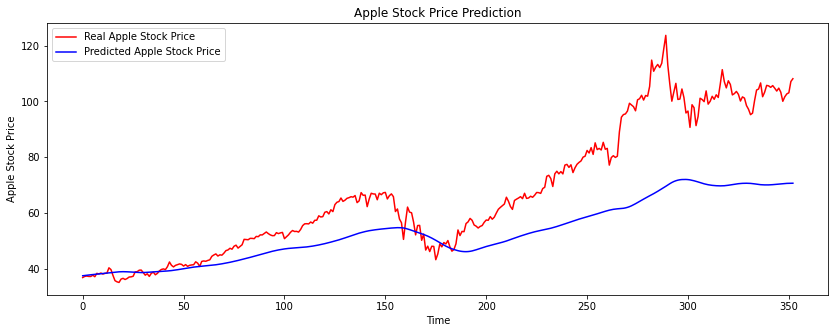

In [ ]:
main()

